# BLUE (Best Linear Unbiased Estimator) for Disk Formation
> Created March. 2025 <br>
> Nikhil Bisht<br>

In [73]:
#import modules
import yt
yt.utilities.logger.disable_stream_logging()
yt.set_log_level(50)
from all_utilities import *
import numpy as np
import h5py

#define paths
SCRATCH = "/home/nbisht/scratch"
RUN_DIR = os.getcwd()
NATURE_RUN = SCRATCH + "/data_assimilation/DiskFormation_9Level_PPM/"
LOWRES_RUN = SCRATCH + "/data_assimilation/DiskFormation_3Level_PPM/"
ANALYSIS_RUN = SCRATCH + "/data_assimilation/DiskFormation_3Level_analysis/"

NATURE_RUN_INITIAL_CONDITIONS = RUN_DIR+"/DiskFormation_9Level_PPM/DiskFormation_9Level_PPM.enzo"
LOWRES_RUN_INITIAL_CONDITIONS = RUN_DIR+"/DiskFormation_3Level_PPM/DiskFormation_9Level_PPM.enzo"
ANALYSIS_RUN_INITIAL_CONDITIONS = RUN_DIR+"/DiskFormation_3Level_analysis/DiskFormation_3Level_analysis.enzo"      #Same as LOWRES RUN

path_to_output_plots = "./plots/"

ALL_FIELDS = ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']


## Visualize Nature run and low resolution run

In [16]:
simulation_visualize(path_to_output_plots,'Density_xy_NatureRun_PPM',NATURE_RUN, 'z', ('gas', 'density'), 51, cbar_range = [1e-2, 1e+3])
simulation_visualize(path_to_output_plots,'Density_xy_LowResRun_PPM',LOWRES_RUN, 'z', ('gas', 'density'), 51, cbar_range = [1e-2, 1e+3])

Parsing Hierarchy : 100%|██████████| 83/83 [00:00<00:00, 6936.05it/s]


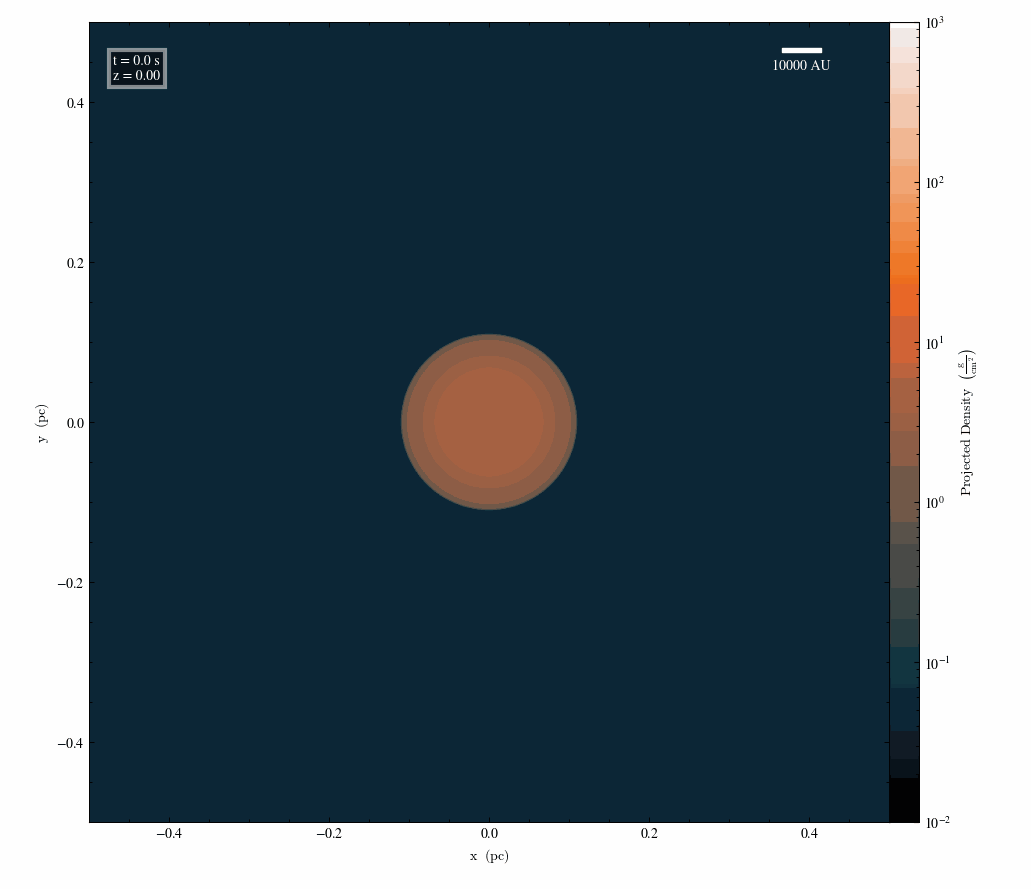

In [17]:
Image(filename=path_to_output_plots+'Density_xy_NatureRun_PPM'+'.gif')

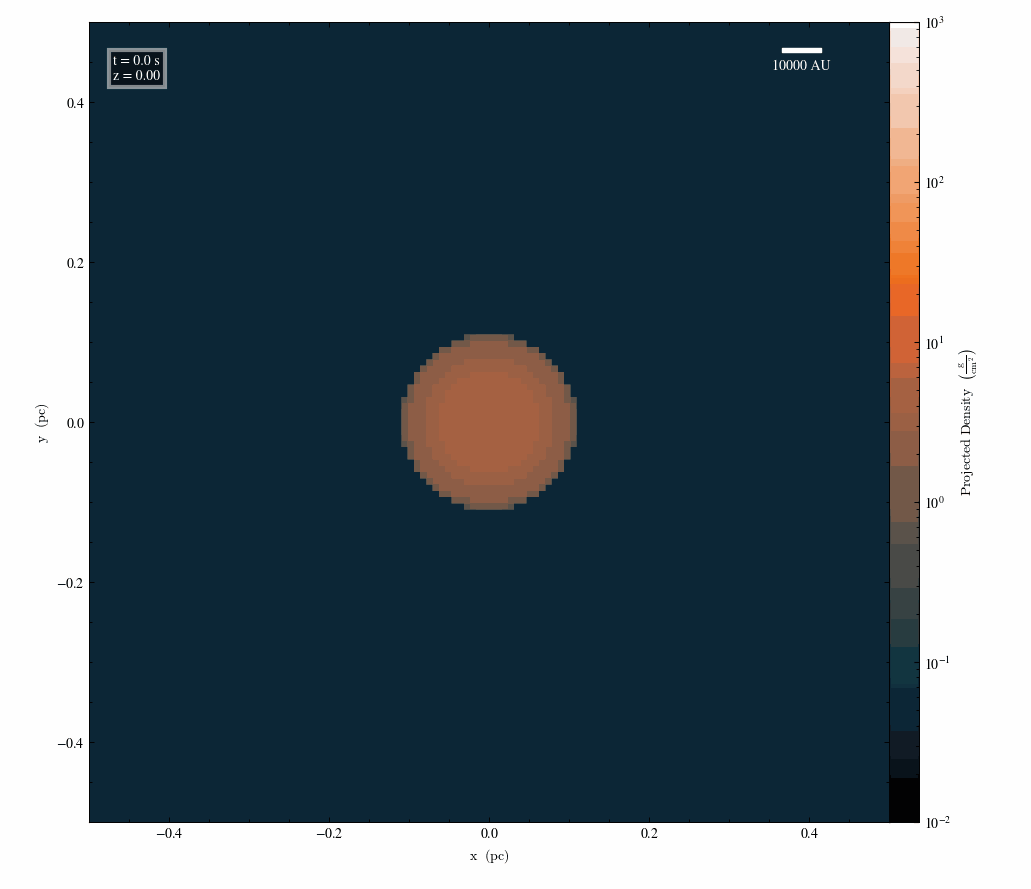

In [18]:
Image(filename=path_to_output_plots+'Density_xy_LowResRun_PPM'+'.gif')

## DA

### Setup

In [2]:
#simulation parameters
START_TIME = 0.0
STOP_TIME = 10.0
dt_DATADUMP = 0.2
ALL_FRAMES = np.arange(START_TIME,STOP_TIME+dt_DATADUMP, dt_DATADUMP)
OBSERVATION_TIMES = [1.0, 3.0, 4.0]

#BLUE solution parameters
alpha_pos = 0.5
beta_pos = 0.5
alpha_vel = 0.5
beta_vel = 0.5
alpha_mag = 0.5
beta_mag = 0.5

Parsing Hierarchy : 100%|██████████| 89/89 [00:00<00:00, 8305.74it/s]


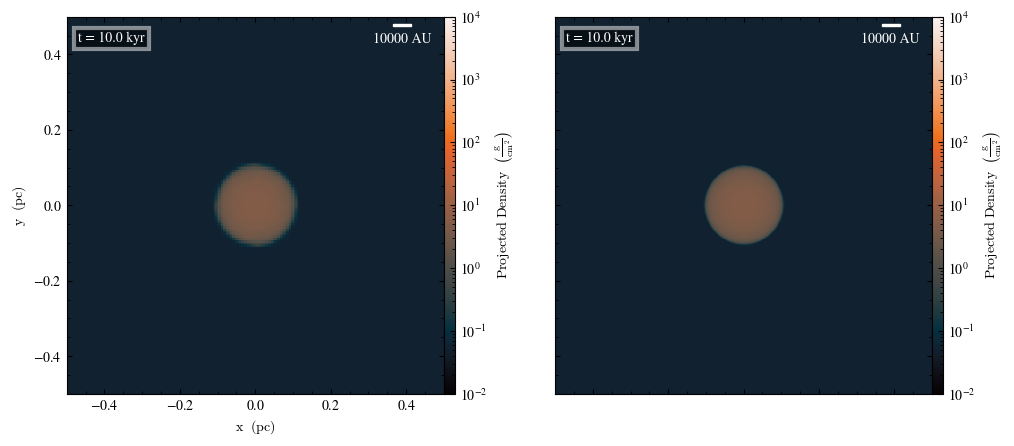

Parsing Hierarchy : 100%|██████████| 124/124 [00:00<00:00, 5924.23it/s]


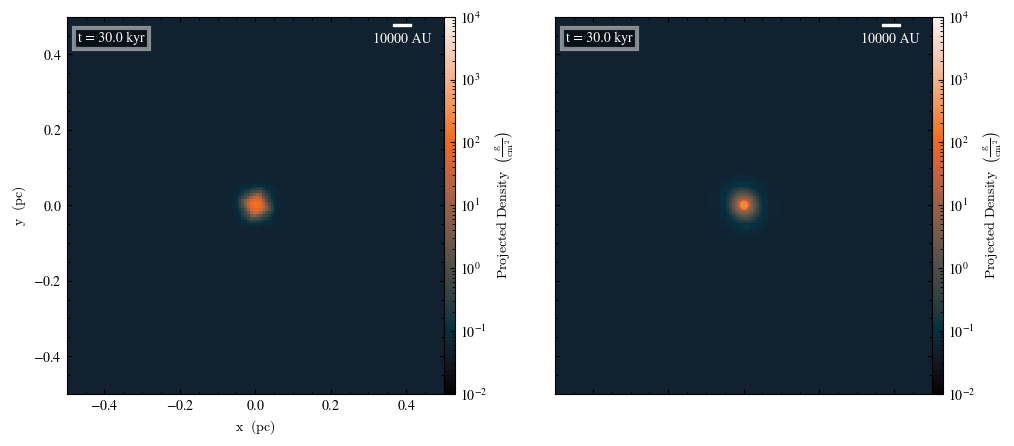

Parsing Hierarchy : 100%|██████████| 367/367 [00:00<00:00, 7288.54it/s]


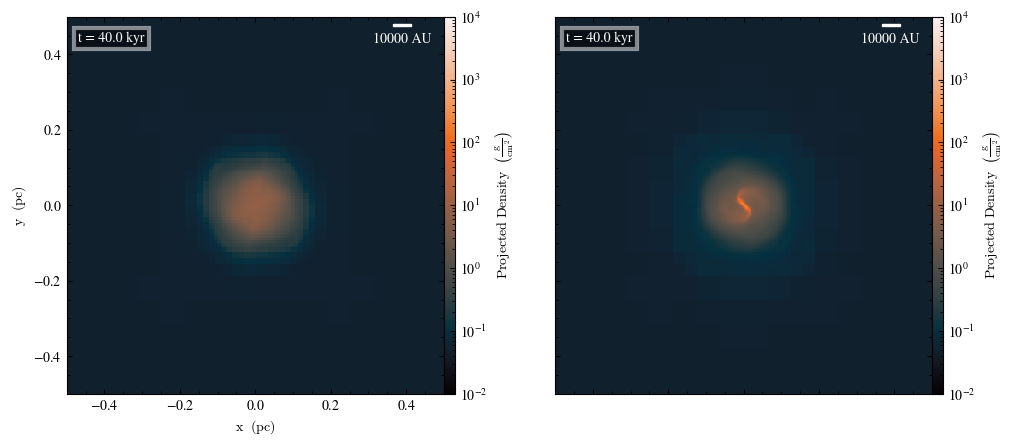

In [8]:
#Compare the two runs for the observation times
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[0], ALL_FRAMES, path_to_output_plots)
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[1], ALL_FRAMES, path_to_output_plots)
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[2], ALL_FRAMES, path_to_output_plots)

### Generating Synthetic Observations
$\boldsymbol{E}^o_n \sim \mathcal{N}(0,\mathbf{R}_n)$ are the Gaussian, unbiased observation errors with covariance $\mathbf{R}_n$. 

$\;$ 

For our problem, the choose the following:

* $\mathbf{R}_n = \sigma_o^2 = (0.1)^2$: the observation error variance is fixed to 0.1 at all times for each grid point

In [3]:
#Generate the synthetic observations at all times
np.random.seed(10)
def generate_observations(input_arr, error_std):
    return input_arr+ np.random.normal(0.0,error_std,size=input_arr.size) # second arg is sigma

### Analysis

In [8]:
#The core analysis function that does the linear combination of observation and background
def analysis_step_assimilate_data(background_arr, observation_arr, alpha, beta):
    return alpha*background_arr+beta*observation_arr
#open analysis simulation files one by one
#grab grid points for each case, use yt to get values in the nature run
#modify and store the modified values
#run the simulation
def analysis_step_get_data(obs_time):
  frame_num = str(np.where(ALL_FRAMES==obs_time)[0][0]).zfill(4)
  #Load the data from nature run
  data_nature = yt.load(NATURE_RUN+"/Data/DD"+frame_num+"/DD"+frame_num)
  code_length = data_nature.length_unit.in_units("code_length")
  #Load the data from analysis run
  #param file has all initial conditions and simulation parameters
  analysis_param_file = open(ANALYSIS_RUN + 'Data/DD'+frame_num+'/DD'+frame_num, 'r')
  NumberOfGhostZones    = 5
  #boundary file has boundary parameters
  analysis_bdry_file = open(ANALYSIS_RUN + 'Data/DD' + frame_num+'/DD' + frame_num+'.boundary', 'r')
  #Not needed in this case but maybe for other periodic boxes?
  analysis_bdry_hdf = h5py.File(ANALYSIS_RUN +'Data/DD' + frame_num+'/DD' + frame_num+'.boundary.hdf', "r")

  #hierarchy file has grid structure; main iterator
  analysis_hrchy_file = open(ANALYSIS_RUN + 'Data/DD' + frame_num+'/DD' + frame_num+'.hierarchy', 'r')
  grid_dict = read_hierarchy_file(analysis_hrchy_file)
  print("Working on grid: ", end=' ')
  for gridnum in list(grid_dict.keys()):
      grid_data = grid_dict[gridnum]
      #if len(grid_data['Pointers'])>=2:
        #if grid_data['Pointers'][0]==0 and grid_data['Pointers'][1]==0: #It's a leaf node
      print('%s'%gridnum, end=' ')
      GridDimReal = np.array(grid_data['GridDimension'])-2*NumberOfGhostZones
      x_gp = np.linspace(grid_data['GridLeftEdge'][0], grid_data['GridRightEdge'][0], GridDimReal[0]+1)*code_length
      y_gp = np.linspace(grid_data['GridLeftEdge'][1], grid_data['GridRightEdge'][1], GridDimReal[1]+1)*code_length
      z_gp = np.linspace(grid_data['GridLeftEdge'][2], grid_data['GridRightEdge'][2], GridDimReal[2]+1)*code_length
      x_grid = (x_gp[1:]+x_gp[:-1])/2
      y_grid = (y_gp[1:]+y_gp[:-1])/2
      z_grid = (z_gp[1:]+z_gp[:-1])/2
      gridpoints = []
      for k in range(len(z_grid)):
        for j in range(len(y_grid)):
          for i in range(len(x_grid)):
            gridpoints.append([x_grid[i], y_grid[j], z_grid[k]])
      gridpoints = np.array(gridpoints)
      #Let's get the actual baryon data now
      analysis_datadump_hdf = h5py.File(ANALYSIS_RUN +grid_data['BaryonFileName'], "a")
      Gridstr = 'Grid'+ str(gridnum).zfill(8)
      for field in ALL_FIELDS:
        field_data = analysis_datadump_hdf[Gridstr][field][()]
        field_data_nature_run = data_nature.find_field_values_at_points([('enzo',field)],gridpoints).reshape((field_data.shape)).to_ndarray()
        if (field_data.shape!=field_data_nature_run.shape):
          print("Shape Mismatch!")
          exit      
        #They are ordered the same and for the same grids! Now to do the update
        field_data_assimilated = analysis_step_assimilate_data(np.array(field_data), field_data_nature_run, 0.1, 0.9)
        analysis_datadump_hdf[Gridstr][field][()] = field_data_assimilated.tolist()
      analysis_datadump_hdf.close()
  print(' ')

  analysis_param_file.close()
  analysis_bdry_file.close()
  analysis_bdry_hdf.close()
  analysis_hrchy_file.close()
  data_nature = None

### Putting it all together

In [9]:
### Initial estimates and covariances
x0 = np.array([-np.pi/2, 3.0]) 
P0 = np.eye(2) # identity matrix of size 2
Q = np.diag([0.1, 0.1]) # covariance of the model errors; assumed constant in time
R = np.array([[0.1]]) # covariance of the observation errors; assumed constant in time

current_time = START_TIME
for obs_time in OBSERVATION_TIMES:
    #Do the first forecasting step, editing the parameter file to run till the first observation time
    edit_enzo_param_file(current_time, obs_time,  ANALYSIS_RUN_INITIAL_CONDITIONS, ANALYSIS_RUN, ALL_FRAMES)
    #run the simulation
    if current_time == START_TIME:
        run_simulation(ANALYSIS_RUN, restart_datadump = None, path_to_initial_conditions = ANALYSIS_RUN_INITIAL_CONDITIONS, num_processors = 8)
    else:
        frame_num = str(np.where(ALL_FRAMES==current_time)[0][0]).zfill(4)
        run_simulation(ANALYSIS_RUN, restart_datadump = './Data/DD'+frame_num+'/DD'+frame_num, path_to_initial_conditions = None, num_processors = 8)
    current_time = obs_time
    #Do the analysis now:
    analysis_step_get_data(current_time)

#Do the last forecasting
edit_enzo_param_file(current_time, STOP_TIME,  ANALYSIS_RUN_INITIAL_CONDITIONS, ANALYSIS_RUN, ALL_FRAMES)
frame_num = str(np.where(ALL_FRAMES==current_time)[0][0]).zfill(4)
run_simulation(ANALYSIS_RUN, restart_datadump = './Data/DD'+frame_num+'/DD'+frame_num, path_to_initial_conditions = None, num_processors = 8)

Time changed
Parameter File updated
/home/nbisht/nazare_desktop/nikhilb_home/projects/data_assimilation_MHD


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GreensFunctionMaxNumber   = 10         // # of greens function at any one time
Global Dir set to .
ENZO_layout 2 x 2 x 2
Successfully read in parameter file /home/nbisht/nazare_desktop/nikhilb_home/projects/data_assimilation_MHD/DiskFormation_3Level_analysis/DiskFormation_3Level_analysis.enzo.
INITIALIZATION TIME =   3.44769569e-01
Continuation Flag = 1
TopGrid dt = 1.804916e-01     time = 0    cycle = 0
TopGrid dt = 1.950838e-02     time = 0.18049156746012    cycle = 1
Continuation Flag = 1
TopGrid dt = 1.753525e-01     time = 0.19999995064325    cycle = 2
TopGrid dt = 2.464797e-02     time = 0.37535249467744    cycle = 3
Continuation Flag = 1
TopGrid dt = 1.705575e-01     time = 0.40000046455053    cycle = 4
TopGrid dt = 2.944300e-02     time = 0.57055794004862    cycle = 5
Continuation Flag = 1
TopGrid dt = 1.657835e-01     time = 0.600000944006    cycle = 

Simulation took 18.47754192352295 seconds
Simulation took 18.47754192352295 seconds
Working on grid:  1 

Parsing Hierarchy : 100%|██████████| 89/89 [00:00<00:00, 9055.02it/s]


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
Time changed
Parameter File updated


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
use_grackle                 = 0
Warning! Density and Mass units are both defined. Using only MassUnits.
Output to Global Dir .
ENZO_layout 2 x 2 x 2
Successfully read ParameterFile ./Data/DD0005/DD0005.
TopGrid dt = 1.549266e-01     time = 1    cycle = 10
TopGrid dt = 4.507594e-02     time = 1.1549265682328    cycle = 11
Continuation Flag = 1
TopGrid dt = 1.528008e-01     time = 1.2000025071432    cycle = 12
TopGrid dt = 4.719943e-02     time = 1.3528032935881    cycle = 13
Continuation Flag = 1
TopGrid dt = 1.493297e-01     time = 1.4000027194706    cycle = 14
TopGrid dt = 5.067066e-02     time = 1.5493324034989    cycle = 15
Continuation Flag = 1
TopGrid dt = 1.440386e-01     time = 1.6000030665597    cycle = 16
TopGrid dt = 5.596189e-02     time = 1.7440417075953    cycle = 17
Continuation Flag = 1
TopGrid dt = 1.382558e-01     time = 1.8000035956292    cyc

Simulation took 39.67165660858154 seconds
Simulation took 39.67165660858154 seconds
Working on grid:  1 

Parsing Hierarchy : 100%|██████████| 124/124 [00:00<00:00, 8860.80it/s]


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
Time changed
Parameter File updated


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
use_grackle                 = 0
Warning! Density and Mass units are both defined. Using only MassUnits.
Output to Global Dir .
ENZO_layout 2 x 2 x 2
Successfully read ParameterFile ./Data/DD0015/DD0015.
TopGrid dt = 1.859032e-02     time = 3    cycle = 33
TopGrid dt = 2.353773e-02     time = 3.0185903176099    cycle = 34
TopGrid dt = 2.446100e-02     time = 3.0421280461674    cycle = 35
TopGrid dt = 2.594420e-02     time = 3.0665890420826    cycle = 36
TopGrid dt = 2.752572e-02     time = 3.0925332395155    cycle = 37
TopGrid dt = 2.784066e-02     time = 3.12005896236    cycle = 38
TopGrid dt = 2.709885e-02     time = 3.1478996233882    cycle = 39
TopGrid dt = 2.500203e-02     time = 3.1749984743908    cycle = 40
Continuation Flag = 1
TopGrid dt = 2.758437e-02     time = 3.2000004999526    cycle = 41
TopGrid dt = 2.826459e-02     time = 3.2275848663552    cycl

Simulation took 94.19858050346375 seconds
Simulation took 94.19858050346375 seconds
Working on grid:  1 

Parsing Hierarchy : 100%|██████████| 367/367 [00:00<00:00, 2139.77it/s]


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26  
Time changed
Parameter File updated


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
use_grackle                 = 0
Warning! Density and Mass units are both defined. Using only MassUnits.
Output to Global Dir .
ENZO_layout 2 x 2 x 2
Successfully read ParameterFile ./Data/DD0020/DD0020.
TopGrid dt = 3.832663e-02     time = 3.9999994075996    cycle = 67
TopGrid dt = 4.044318e-02     time = 4.0383260399212    cycle = 68
TopGrid dt = 4.102959e-02     time = 4.0787692236804    cycle = 69
TopGrid dt = 4.097260e-02     time = 4.1197988102096    cycle = 70
TopGrid dt = 3.923051e-02     time = 4.1607714083889    cycle = 71
Continuation Flag = 1
TopGrid dt = 4.083623e-02     time = 4.2000019226592    cycle = 72
TopGrid dt = 4.102419e-02     time = 4.2408381509144    cycle = 73
TopGrid dt = 4.145175e-02     time = 4.281862337398    cycle = 74
TopGrid dt = 4.201447e-02     time = 4.3233140916478    cycle = 75
TopGrid dt = 3.467290e-02     time = 4.365328

Simulation took 1169.9421157836914 seconds
Simulation took 1169.9421157836914 seconds


Continuation Flag = 1
Successful run, exiting.


## Visualizing DA solution and comparison with nature run

In [11]:
simulation_visualize(path_to_output_plots,'Density_xy_AnalysisRun_PPM',ANALYSIS_RUN, 'z', ('gas', 'density'), 50, cbar_range = [1e-2, 1e+3])

Parsing Hierarchy : 100%|██████████| 45/45 [00:00<00:00, 8333.42it/s]


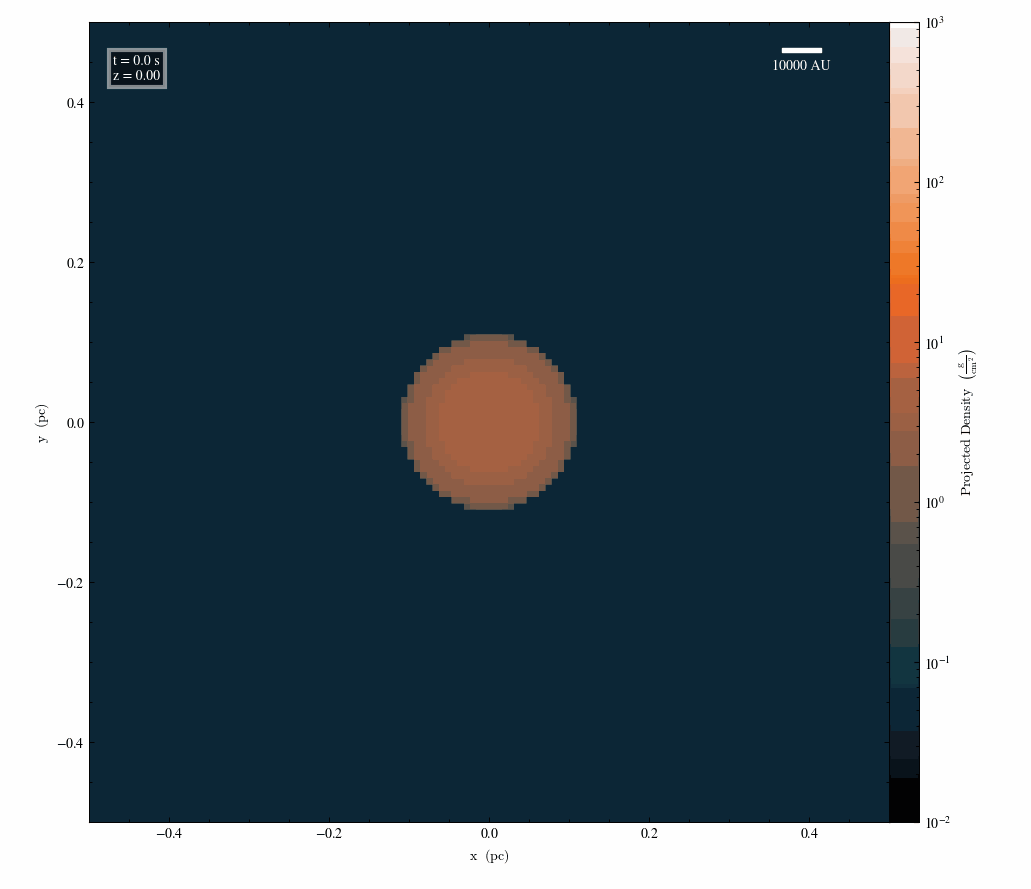

In [35]:
Image(filename=path_to_output_plots+'Density_xy_AnalysisRun_PPM'+'.gif')

Parsing Hierarchy : 100%|██████████| 53/53 [00:00<00:00, 7340.93it/s]


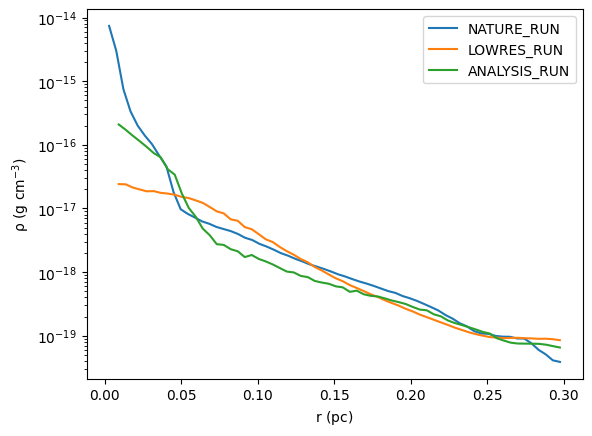

In [34]:
#Let's do density profile analysis
import matplotlib.pyplot as plt
def density_profile_comparison(plot_dir, PlotType, all_paths, dataset_to_plot, frame):
    label_name = ['NATURE_RUN','LOWRES_RUN','ANALYSIS_RUN']
    frame_str = str(frame).zfill(4)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(3):
        ds = yt.load(all_paths[i]+"/Data/DD"+frame_str+"/DD"+frame_str)
        # Get a sphere object
        sp = ds.sphere(ds.domain_center, (0.3, "pc"))
        # Bin up the data from the sphere into a radial profile
        rp = yt.create_profile(sp,"radius",dataset_to_plot, units={"radius": "pc"},logs={"radius": False})
        # Plot the density as a log-log plot using the default settings
        dens_plot = ax.plot(rp.x.value, rp["gas", "density"].value, label = label_name[i])
    # Here we set the labels of the plot axes
    ax.set_xlabel(r"$\mathrm{r\ (pc)}$")
    ax.set_yscale('log')
    ax.set_ylabel(r"$\mathrm{\rho\ (g\ cm^{-3})}$")
    plt.legend()
    # Save the default plot
    fig.savefig(plot_dir+PlotType+"_DD"+frame_str+".png")
    # The "dens_plot" object is a list of plot objects. In our case we only have one,
    # so we index the list by '0' to get it.

density_profile_comparison(path_to_output_plots,'Density_profile_Comparison',[NATURE_RUN,LOWRES_RUN,ANALYSIS_RUN], ('gas', 'density'), 30)

Parsing Hierarchy : 100%|██████████| 83/83 [00:00<00:00, 9182.02it/s]


KeyboardInterrupt: 

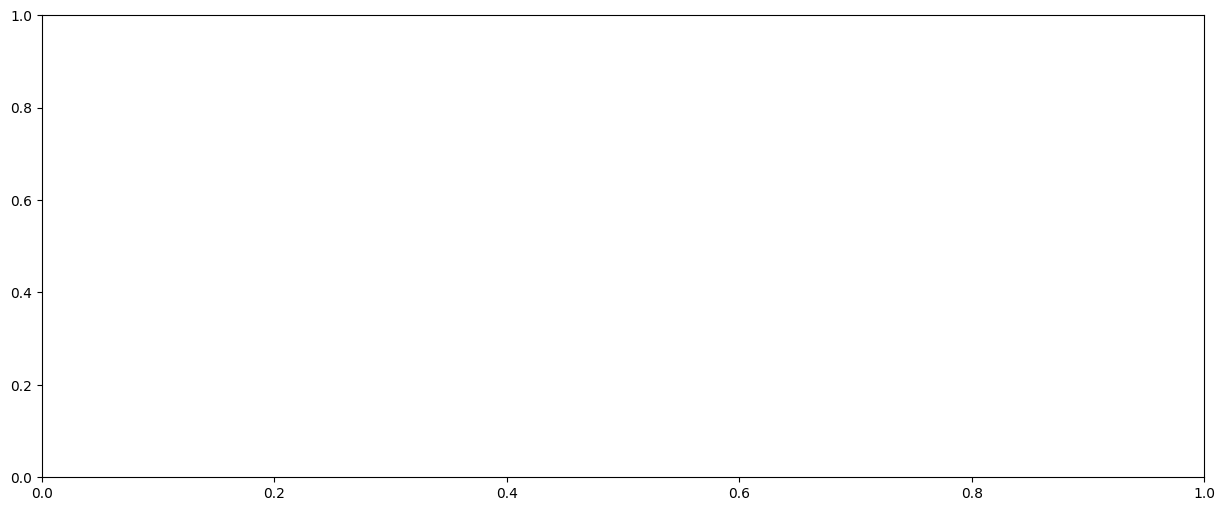

In [74]:
import matplotlib.ticker as mticker
obs_frames = []
for obs in OBSERVATION_TIMES:
    obs_frames.append(np.where(ALL_FRAMES==obs)[0][0])

def get_sum_of_difference(arr1,arr2):
    #finds nans and removes them from the sum
    mask1 = np.where(np.logical_or(np.equal(arr1,-np.inf), np.equal(arr1,np.inf)))
    mask2 = np.where(np.logical_or(np.equal(arr2,-np.inf), np.equal(arr2,np.inf)))
    mask_and = np.concatenate((mask1[0],mask2[0]))
    _, i = np.unique(mask_and, return_index=True)
    mask_and = np.sort(mask_and[i])
    return np.abs(np.delete(arr1, mask_and)-np.delete(arr2, mask_and)).sum()

def density_profile_comparison_over_time(plot_dir, PlotType, all_paths, dataset_to_plot, obs_frames):
    label_name = ['NATURE_RUN','LOWRES_RUN','ANALYSIS_RUN']
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    diff_lowres = []
    diff_analysis = []
    frames = []
    for frame in range(51):
        frames.append(frame)
        frame_str = str(frame).zfill(4)
        xvals = [0,0,0]
        yvals= [0,0,0]
        bins = np.linspace(0,0.3,50)
        for i in range(3):
            ds = yt.load(all_paths[i]+"/Data/DD"+frame_str+"/DD"+frame_str)
            # Get a sphere object
            sp = ds.sphere(ds.domain_center, (0.3, "pc"))
            # Bin up the data from the sphere into a radial profile
            rp = yt.create_profile(sp,"radius",dataset_to_plot, units={"radius": "pc"},logs={"radius": False}, override_bins={"radius": bins})
            xvals[i] = rp.x.value
            yvals[i] = rp["gas", "density"].value
        diff_lowres.append(get_sum_of_difference(np.log10(yvals[0]), np.log10(yvals[1])))
        diff_analysis.append(get_sum_of_difference(np.log10(yvals[0]), np.log10(yvals[2])))
    ax.plot(frames, diff_lowres, label = 'LOWRES_difference', c = 'blue')
    ax.plot(frames, diff_analysis, label = 'Analysis_difference', c = 'black')
    for obs in obs_frames:
        if obs == obs_frames[0]:
            label_name = 'Observation frames'
        else:
            label_name = None
        ax.axvline(obs, c='red', ls = '--', label = label_name)
    #dens_plot = ax.plot(, , label = label_name[i])
    # Here we set the labels of the plot axes
    ax.set_xlabel("Frames")
    ax.set_ylabel(r"$\mathrm{\Delta \rho\ (log_{10} g\ cm^{-3})}$")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.xlim([-0.5,50])
    plt.legend()
    # Save the default plot
    fig.savefig(plot_dir+PlotType+".png")

density_profile_comparison_over_time(path_to_output_plots,'Density_profile_Comparison_over_time',[NATURE_RUN,LOWRES_RUN,ANALYSIS_RUN], ('gas', 'density'),obs_frames)